In [1]:
library(pracma)
library(matrixcalc)
library(fields)
library(Matrix)
#load source file
src.path <- "../src"
source(paste(src.path, "DataGenerationProcess", "synth_basis.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_data.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_graph.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_linearop.R", sep="/"))

source(paste(src.path, "Estimation", "basis_estimation.R", sep="/"))
source(paste(src.path, "Utility", "utility.R", sep="/"))
source(paste(src.path, "Estimation", "cca_estimation.R", sep="/"))
source(paste(src.path, "Utility", "R2python.R", sep="/"))
###specify save path and filename


Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


Attaching package: 'Matrix'


The following object is masked from 'package:spam':

    det


The following objects are masked from 'package:pracma':

    expm, lu, tril, triu


Loading required package: splines

Loading required package: fds

Loading required package: rainbow

Loading required package: MASS

Loading required package: pcaPP

Loading required package: RCurl

Loading required package: deSolve


Attaching pack

In [10]:
cov_name="tridiag3"

###specify parameters
n <- 200
PP <- 50
k.gen <- 9
M <- 2
obs.time <- seq(0,1,1/50)


gendata <- function(N, seed_id){
for (n in c(N)){
    for (p in c(PP)){
        ## be careful for the choice of the number of basis function 
## fourier basis: km must be odd
## bspline basis km>4
km.gen <- c(9,9)

Apinv_list <- list()
A_list <- list()
N_list <- list()
basis.m_list <- list()
true.basis_list <- list()
true.values_list <- list()




#generate data from the graph

if (cov_name == "random"){
    omega <- synth.omega.random(p, k.gen, drop=0.1)
}
if (cov_name == "power"){
    omega <- synth.omega.power(p, k.gen)
    omega <- solve(omega)
}
if (cov_name == "tridiag1"){
    omega <- synth.omega.tridiag1(p, k.gen)
}
if (cov_name == "tridiag2"){
    omega <- synth.omega.tridiag2(p, k.gen)
}
if (cov_name == "tridiag3"){
    omega <- synth.omega.tridiag3(p, k.gen)
}

#ensure that the diagonal values are all 1

G.true <- matrix(0, p, p) # p by p adjacency matrix
for(i in 1:p){
  for(j in 1:p){
    if(sum(abs(omega[((i-1)*k.gen+1):(i*k.gen), ((j-1)*k.gen+1):(j*k.gen)])) > 0)
      G.true[i,j] <- 1
  }
}

cov <- solve(omega)

for(m in 1:M){
    Am <- synth.linear_op.sparse_orthogonal(k.gen, km.gen[m], 3, scale=m*0.1)
    Am <- t(t(Am) %*% diag(.2*((1:k.gen))+1)) #this is to make the singular values distinct

    A_list[[m]] <- Am
    Apinv_list[[m]] <- solve(Am)
    #noise covariance
    N_list[[m]] <- diag(p*km.gen[m])*.001
    #structured noise
    basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km.gen[m])
}

#convert to regression B
B_list <- utility.graph2B(omega,p)
# save true graphs


#generate data 
#set.seed(seed_id)
#multivariate_data <- synth.dependent_data(n, p, cov, Apinv_list, N_list)
#set.seed(seed_id)
data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list,N_list, dependent=TRUE, addnoise=FALSE)


concate_data <- list()
for(m in 1:2){
        dm <- data[[m]][,1,]
    for(i in 2:p){
        dm <- rbind(dm, data[[m]][,p,])
    }
    concate_data[[m]] <- dm
}
fourier.basis1 <- create.fourier.basis(rangeval=c(0,1), nbasis=km.gen[1])
d1 <-Data2fd(argvals=obs.time, y=t(concate_data[[1]]), basisobj=fourier.basis1)
#data modality 2
fourier.basis2 <- create.fourier.basis(rangeval=c(0,1), nbasis=km.gen[2])
d2 <-Data2fd(argvals=obs.time, y=t(concate_data[[2]]), basisobj=fourier.basis2)

cca.r.est <- estimate.cca.basis_expansion(d1, d2, km.gen[1])

##save data 
est_Ac <- list()
est_Ac[[1]] <- cca.r.est$A1
est_Ac[[2]] <- cca.r.est$A2 

fourier.basis1 <- create.fourier.basis(rangeval=c(0,1), nbasis=km.gen[1])
d1 <-Data2fd(argvals=obs.time, y=t(data[[1]][,1,]), basisobj=fourier.basis1)
#data modality 2
fourier.basis2 <- create.fourier.basis(rangeval=c(0,1), nbasis=km.gen[2])
d2 <-Data2fd(argvals=obs.time, y=t(data[[2]][,1,]), basisobj=fourier.basis2)

cca.r.est <- estimate.cca.basis_expansion(d1, d2, km.gen[1])

##save data 
est_A <- list()
est_A[[1]] <- cca.r.est$A1
est_A[[2]] <- cca.r.est$A2 


#cca.r.est <- estimate.multivariate.cca(multivariate_data[[1]][,1:9], multivariate_data[[2]][,1:9],9)

#est_Am <- list()
#est_Am[[1]] <- cca.r.est$A1
#est_Am[[2]] <- cca.r.est$A2 

}
}
A <- list()
#A$est_Am <- est_Am
A$est_A  <- est_A
A$A_list <- A_list
A$est_Ac <- est_Ac
return(A)
}

In [11]:
diff_A_list <- list()
diff_Ac_list <- list()

for(iter in 1:20){
    diff_Am <- list()
    diff_A <- list()
    diff_Ac <- list()


    for(n in c(275, 305, 344, 393, 458, 550, 688, 917, 1376, 2752, 13761)){
        A<-gendata(n, iter)

        A_list <- A$A_list
        est_Am <- A$est_Am
        est_A  <- A$est_A 
        est_Ac <- A$est_Ac
        for(i in 1:9){
            if(norm(est_A[[1]][i,]+A_list[[1]][i,]) < norm(est_A[[1]][i,]-A_list[[1]][i,])){
                est_A[[1]][i,] <- - est_A[[1]][i,] 
            }

        }

        for(i in 1:9){
            
            if(norm(est_A[[2]][i,]+A_list[[2]][i,]) < norm(est_A[[2]][i,]-A_list[[2]][i,])){
                est_A[[2]][i,] <- - est_A[[2]][i,] 
            }
        }

        for(i in 1:9){
            if(norm(est_Am[[1]][i,]+A_list[[1]][i,]) < norm(est_Am[[1]][i,]-A_list[[1]][i,])){
                est_Am[[1]][i,] <- - est_Am[[1]][i,] 
            }

        }

        for(i in 1:9){
            
        if(norm(est_Am[[2]][i,]+A_list[[2]][i,]) < norm(est_Am[[2]][i,]-A_list[[2]][i,])){
                est_Am[[2]][i,] <- - est_Am[[2]][i,] 
            }
        }

        for(i in 1:9){
            if(norm(est_Ac[[1]][i,]+A_list[[1]][i,]) < norm(est_Ac[[1]][i,]-A_list[[1]][i,])){
                est_Ac[[1]][i,] <- - est_Ac[[1]][i,] 
            }

        }

        for(i in 1:9){
            
            if(norm(est_Ac[[2]][i,]+A_list[[2]][i,]) < norm(est_Ac[[2]][i,]-A_list[[2]][i,])){
                est_Ac[[2]][i,] <- - est_Ac[[2]][i,] 
            }
        }

        tempA <- norm(est_A[[1]]-A_list[[1]])**2 + norm(est_A[[2]]-A_list[[2]])**2
        diff_A <- c(diff_A, tempA)

        tempAm <- norm(est_Am[[1]]-A_list[[1]])**2 + norm(est_Am[[2]]-A_list[[2]])**2
        diff_Am <- c(diff_Am, tempAm)


        tempAc <- norm(est_Ac[[1]]-A_list[[1]])**2 + norm(est_Ac[[2]]-A_list[[2]])**2
        diff_Ac <- c(diff_Ac, tempAc)

    }

    diff_A_list[[iter]] <- diff_A
    diff_Ac_list[[iter]] <- diff_Ac
}



[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] "canonical correlation values:"
[1] 0.9999361 0.9999164 0.9999052 0.9998768 0.9998051 0.9997753 0.9997504
[8] 0.9996720 0.9996500
[1] "canonical correlation values:"
[1] 0.9999543 0.9999193 0.9998919 0.9998668 0.9998240 0.9998116 0.9997620
[8] 0.9997293 0.9995645
[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] "canonical correlation values:"
[1] 0.9999432 0.9999148 0.9998833 0.9998444 0.9998127 0.9997782 0.9997417
[8] 0.9997143 0.9996337
[1] "canonical correlation values:"
[1] 0.9999437 0.9999188 0.9998989 0.9998766 0.9998371 0.9997951 0.9997395
[8] 0.9996506 0.9995607
[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] "canonical correlation values:"
[1] 0.9999566 0.9999205 0.9998938 0.9998766 0.9998385 0.9998154 0.9997712
[8] 0.9996365 0.9995789
[1] "canonical correlation values:"
[1] 0.9999404 0.9999208 0.9998928 0.9998541 0.9998277 0.9997775 0.

In [12]:
remove_outlier <- function(data_list, a = 2){
    data.mean <- mean(unlist(data_list))
    data.std  <- std(unlist(data_list))
    return.list <- list()
    for(data in data_list){
        if(data <= data.mean + a*data.std){
            if(data >= data.mean - a*data.std){
                return.list <- append(return.list, data)
            }
        }
        
    }
    return(return.list)
}

In [13]:
for(n in 1:11){
    Alist <- list()
    for(iter in 1:20){
        A_list[[iter]] <- diff_Ac_list[[iter]][n]
    }
    print(paste(mean(unlist(A_list)), std(unlist(A_list))))
    A_list_rm <- remove_outlier(A_list)

    
}

print('remove outlier')
for(n in 1:11){
    Alist <- list()
    for(iter in 1:20){
        A_list[[iter]] <- diff_Ac_list[[iter]][n]
    }

    A_list_rm <- remove_outlier(A_list)
    
    print(paste(mean(unlist(A_list_rm)), std(unlist(A_list_rm))))
    
}

[1] "1.95648673393663 0.817448968889786"
[1] "1.60828743100534 0.722675972849969"
[1] "1.85821152235656 0.995541712467052"
[1] "1.35705204220599 0.705098149579634"
[1] "1.16618371243781 0.431166005205211"
[1] "1.48118215079893 0.749572479659238"
[1] "1.15864354226874 0.582358969665707"
[1] "1.18841157555482 0.622294399487069"
[1] "0.670552069483534 0.166942726777219"
[1] "0.620850239061518 0.187104125958004"
[1] "0.531491999563558 0.118318303674354"
[1] "remove outlier"
[1] "1.76818564532147 0.609165710699669"
[1] "1.52590184202062 0.638737655652064"
[1] "1.70978650701231 0.762290712829795"
[1] "1.18377278632591 0.486409274731013"
[1] "1.16618371243781 0.431166005205211"
[1] "1.37755111120731 0.605270832106879"
[1] "1.01001418273396 0.380929488547226"
[1] "1.07035264992386 0.338407241762803"
[1] "0.646352764781569 0.130596323367981"
[1] "0.598148397488234 0.161470525853386"
[1] "0.531491999563558 0.118318303674354"


In [14]:
for(n in 1:11){
    Alist <- list()
    for(iter in 1:20){
        A_list[[iter]] <- diff_A_list[[iter]][n]
    }
    print(paste(mean(unlist(A_list)), std(unlist(A_list))))

}


print('remove outlier')
for(n in 1:11){
    Alist <- list()
    for(iter in 1:20){
        A_list[[iter]] <- diff_A_list[[iter]][n]
    }

    A_list_rm <- remove_outlier(A_list)
    
    print(paste(mean(unlist(A_list_rm)), std(unlist(A_list_rm))))
    
}

[1] "1.99517749736713 0.806176032884156"
[1] "1.48509274876081 0.47321569173916"
[1] "1.62733899427839 0.787387530432409"
[1] "1.62754072822034 0.815948699434401"
[1] "1.16578395830792 0.435829700485784"
[1] "1.22539165125174 0.602029574624674"
[1] "1.08875387030375 0.493458852009037"
[1] "1.04430748721658 0.447161847000213"
[1] "0.668866773391385 0.261236965723689"
[1] "0.62142966942181 0.182723425966666"
[1] "0.537121589529522 0.0973170553013358"
[1] "remove outlier"
[1] "1.89535157084392 0.689673602090862"
[1] "1.42260414260874 0.392350104831308"
[1] "1.42449182122233 0.502382518596473"
[1] "1.48336227627332 0.51372557740526"
[1] "1.16578395830792 0.435829700485784"
[1] "1.15473728714801 0.526486133736882"
[1] "0.960447516947078 0.308562789931331"
[1] "0.987445714669549 0.377894854828699"
[1] "0.62749749579641 0.189489340660696"
[1] "0.62142966942181 0.182723425966666"
[1] "0.525109074077465 0.0833691174347529"


In [18]:
typeof(diff_A)

[1] "list"

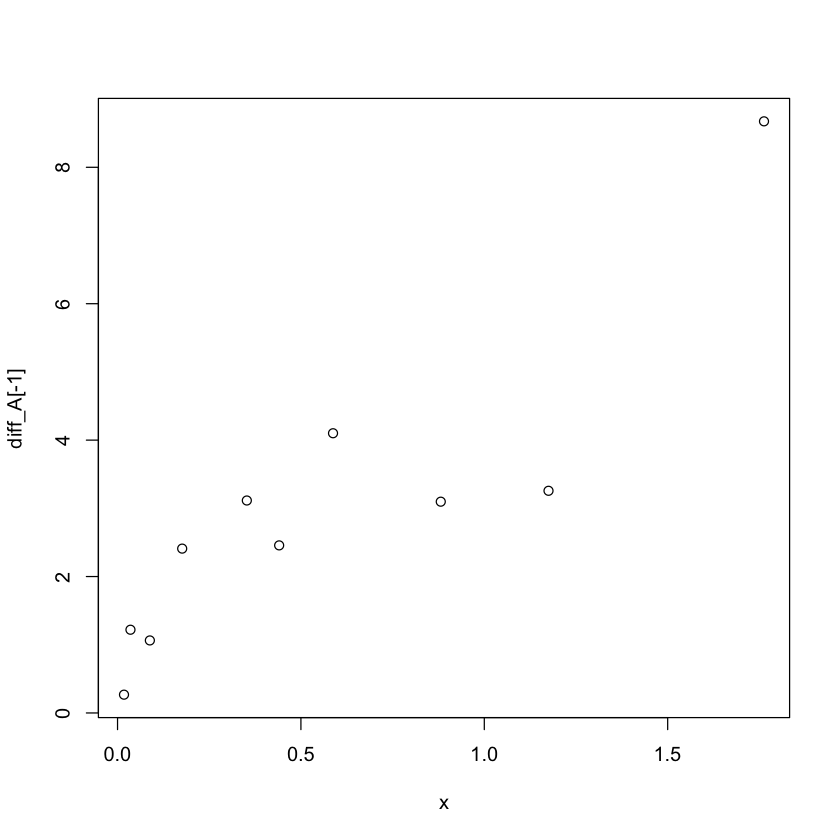

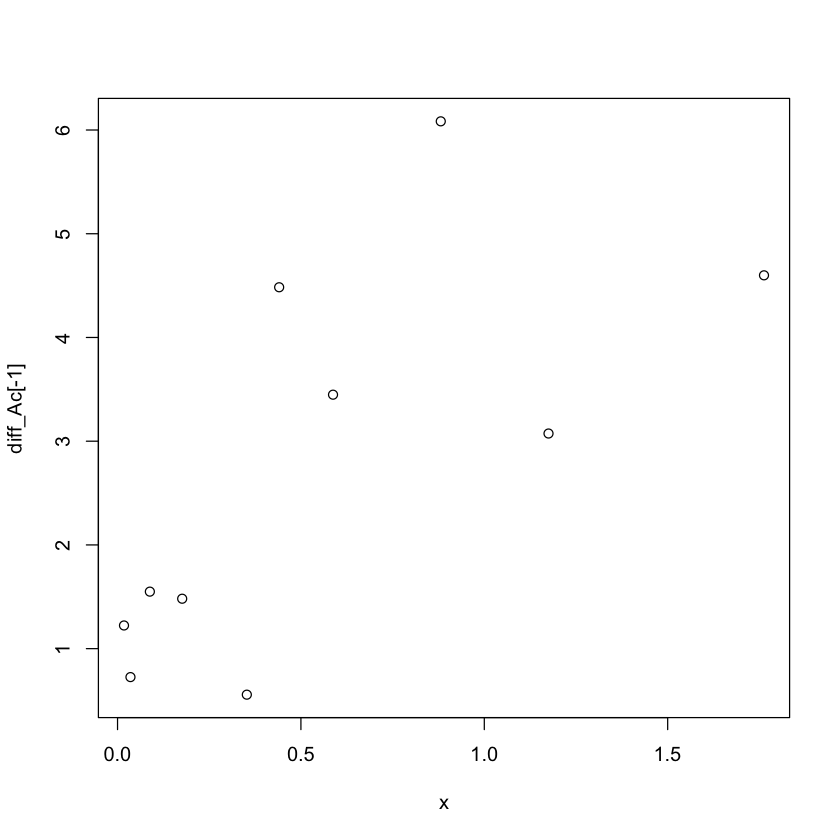

In [8]:
x <- list()
for(n in c(100,150,200,300,400,500,2000,1000,5000,10000)){
    x <- c(x, 81*log10(150)/n)
}
#par(bg='white')
#plot(x,diff_Am)
#print(diff_Am)
par(bg='white')
plot(x,diff_A[-1])
#print(diff_A)

par(bg='white')
plot(x,diff_Ac[-1])
#print(diff_Ac)


[1] "difference A1 (before callibration) 0.508976250839641"
[1] "difference A1 0.508976250839641"
[1] "difference A2 (before calibration) 0.980398739623915"
[1] "difference A2 0.980398739623915"


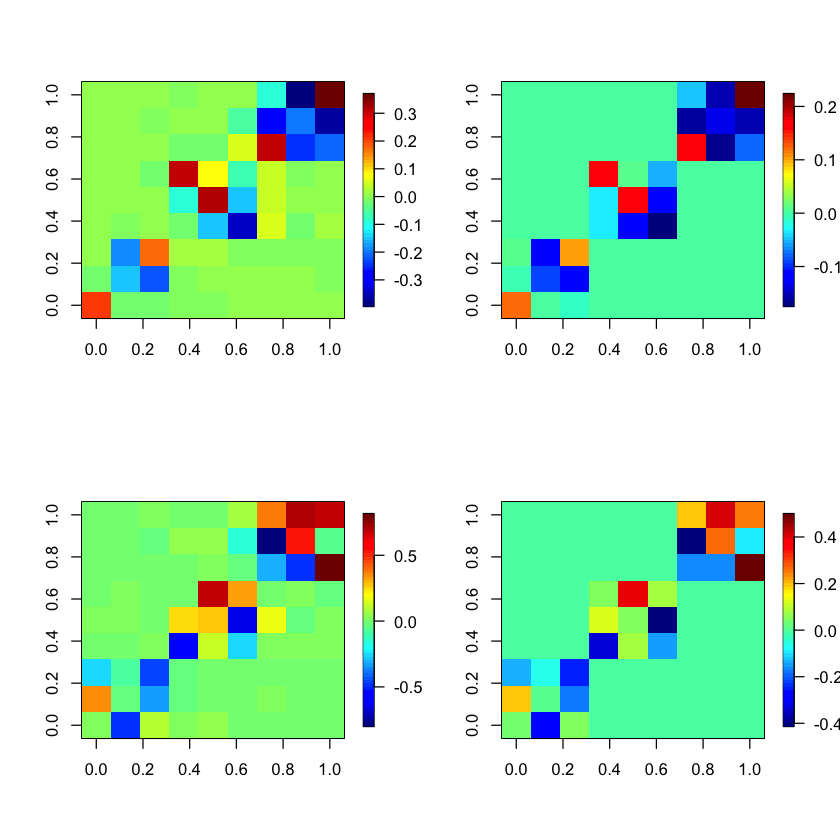

[1] "difference A1 (before callibration) 0.393538928620845"
[1] "difference A1 0.393538928620845"
[1] "difference A2 (before callibration) 0.755596480340357"
[1] "difference A2 0.755596480340357"


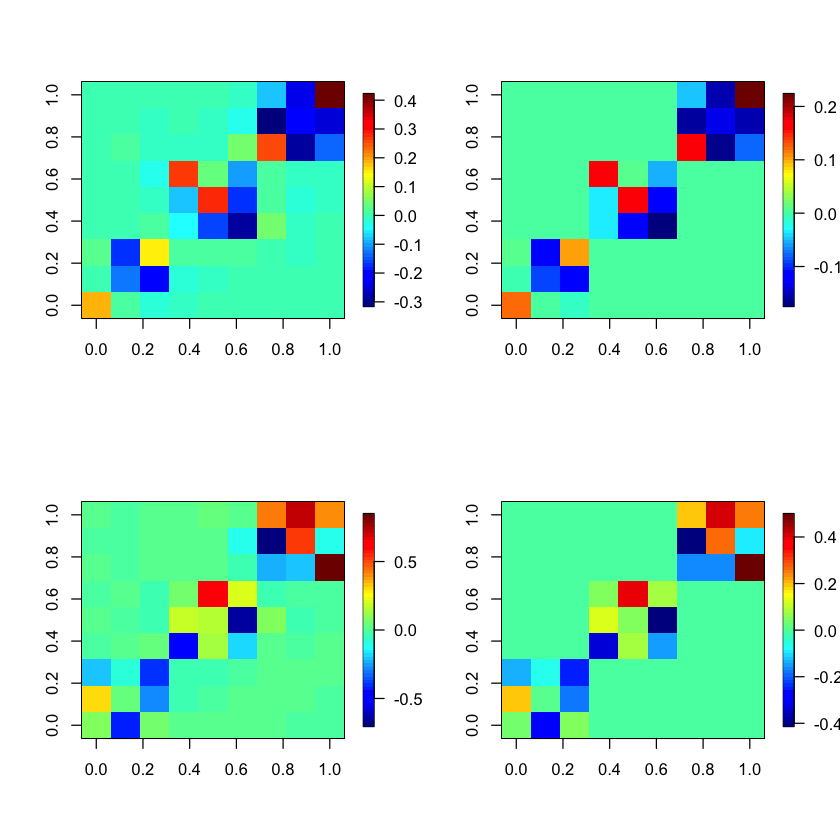

[1] "difference A1 (before callibration) 0.429429359814019"
[1] "difference A1 0.429429359814019"
[1] "difference A2 (before callibration) 0.823748968286851"
[1] "difference A2 0.823748968286851"


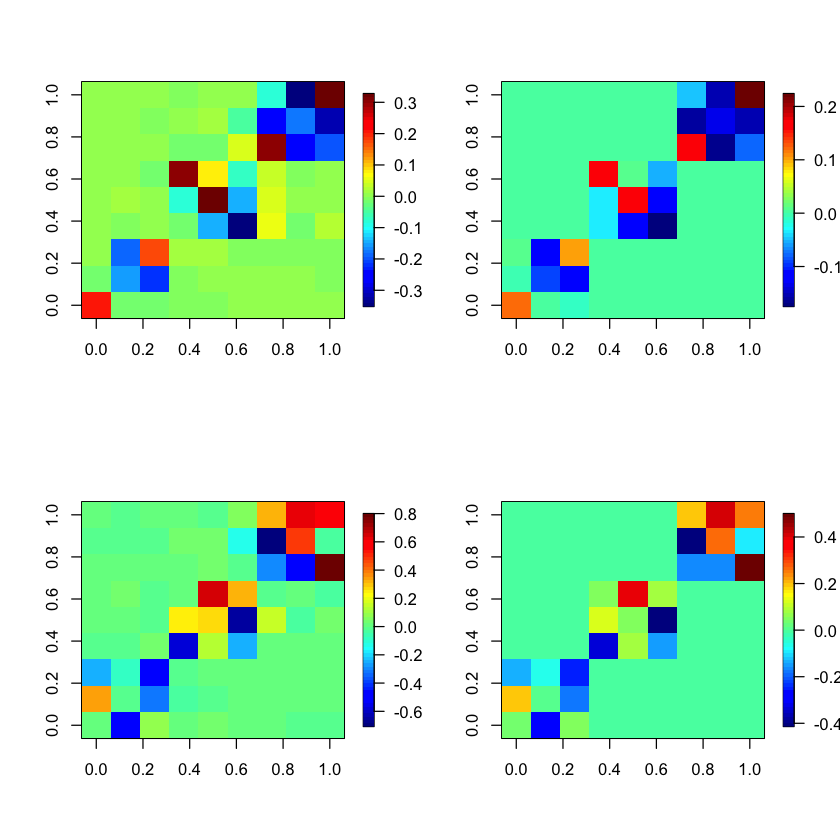

In [5]:
print(paste('difference A1 (before callibration)', norm(est_A[[1]] - A_list[[1]])))
for(i in 1:9){
    if(norm(est_A[[1]][i,]+A_list[[1]][i,]) < norm(est_A[[1]][i,]-A_list[[1]][i,])){
        est_A[[1]][i,] <- - est_A[[1]][i,] 
    }

}
print(paste('difference A1', norm(est_A[[1]] - A_list[[1]])))
print(paste('difference A2 (before calibration)', norm(est_A[[2]] - A_list[[2]])))
for(i in 1:9){
    
    if(norm(est_A[[2]][i,]+A_list[[2]][i,]) < norm(est_A[[2]][i,]-A_list[[2]][i,])){
        est_A[[2]][i,] <- - est_A[[2]][i,] 
    }
}
print(paste('difference A2', norm(est_A[[2]] - A_list[[2]])))
par(bg="white", mfrow=c(2,2))
image.plot(est_A[[1]])
image.plot(A_list[[1]])


image.plot(est_A[[2]])
image.plot(A_list[[2]])


par(bg="white", mfrow=c(2,2))
image.plot(est_Ac[[1]])
image.plot(A_list[[1]])

image.plot(est_Ac[[2]])
image.plot(A_list[[2]])


print(paste('difference A1 (before callibration)', norm(est_Ac[[1]] - A_list[[1]])))
for(i in 1:9){
    if(norm(est_Ac[[1]][i,]+A_list[[1]][i,]) < norm(est_Ac[[1]][i,]-A_list[[1]][i,])){
        est_Ac[[1]][i,] <- - est_Ac[[1]][i,] 
    }

}
print(paste('difference A1', norm(est_Ac[[1]] - A_list[[1]])))
print(paste('difference A2 (before callibration)', norm(est_Ac[[2]] - A_list[[2]])))
for(i in 1:9){
    
    if(norm(est_Ac[[2]][i,]+A_list[[2]][i,]) < norm(est_Ac[[2]][i,]-A_list[[2]][i,])){
        est_Ac[[2]][i,] <- - est_Ac[[2]][i,] 
    }
}
print(paste('difference A2', norm(est_Ac[[2]] - A_list[[2]])))
par(bg="white", mfrow=c(2,2))
image.plot(est_Ac[[1]])
image.plot(A_list[[1]])

image.plot(est_Ac[[2]])
image.plot(A_list[[2]])


par(bg="white", mfrow=c(2,2))
image.plot(est_Am[[1]])
image.plot(A_list[[1]])


image.plot(est_Am[[2]])
image.plot(A_list[[2]])
print(paste('difference A1 (before callibration)', norm(est_Am[[1]] - A_list[[1]])))
for(i in 1:9){
    if(norm(est_Am[[1]][i,]+A_list[[1]][i,]) < norm(est_Am[[1]][i,]-A_list[[1]][i,])){
        est_Am[[1]][i,] <- - est_Am[[1]][i,] 
    }

}
print(paste('difference A1', norm(est_Am[[1]] - A_list[[1]])))
print(paste('difference A2 (before callibration)', norm(est_Am[[2]] - A_list[[2]])))
for(i in 1:9){
    
    if(norm(est_Am[[2]][i,]+A_list[[2]][i,]) < norm(est_Am[[2]][i,]-A_list[[2]][i,])){
        est_Am[[2]][i,] <- - est_Am[[2]][i,] 
    }
}
print(paste('difference A2', norm(est_Am[[2]] - A_list[[2]])))
par(bg="white", mfrow=c(2,2))
image.plot(est_Am[[1]])
image.plot(A_list[[1]])


image.plot(est_Am[[2]])
image.plot(A_list[[2]])